## 1. Import Libraries

In [2]:
import sys
import numpy as np
import pandas  as  pd
import networkx as nx
from tqdm.notebook import tqdm
from datetime import date
import matplotlib.pyplot as plt

import torch
from torch_geometric.utils import k_hop_subgraph, to_networkx

%matplotlib inline

sys.path.append('../')
from src.fakenews import LabelFeature_Experiment


Using backend: pytorch[13:42:49] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/csgpu/anaconda3/envs/tf-gpu-cuda10/lib/python3.9/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.0.so: cannot open shared object file: No such file or directory



## 2. Prepare Model&Data

### 2.1 Load dataset

In [19]:
feature_names = ['alexa_rank','daily_pageviews_per_visitor','daily_time_on_site','total_sites_linking_in','bounce_rate']
syn_labels = [f'x{i}' for i in range(32)]
empty_list =  []
coeffs = { 'model_type': 'gcn',
          'epoch':10000,
          'num_layers':4,
          'dim':48,
          'use_batch':False,
          'outer_batch_size':5000,
          'fan_out':[-1,25,10],
          'inner_batch_size':40,
          'train_percentage':0.8,
          'seed':0,
          'experiment_id':4,
          'gpu_id':-1,
          'extra':'s1',
          'labelfeature_names':['feat_label_ben','feat_label_mal','feat_label_unknown'],
          # 'labelfeature_names':['feat_pred_ben_def','feat_pred_mal_def'],
          # 'use_syn':True,
          'syn_labels':syn_labels,
          'syn_file':'../fakenews/data/fakenews_xavier.csv'
}
nodes_file = '../data/features7.csv'
edges_file = '../data/edges2.csv'

model_file = f"""../model/fakenews_{coeffs['model_type']}.pkl"""      

exp = LabelFeature_Experiment(nodes_file, edges_file, feature_names, **coeffs)


Train tensor(686) Test tensor(173)
Data converted to undirected: True
Data(x=[26573, 5], edge_index=[2, 78600], y=[26573], train_mask=[26573], test_mask=[26573], validation_mask=[26573])


### 2.2 Visualize the graph

Train tensor(686) Test tensor(173)
Data converted to undirected: True
Data(x=[26573, 5], edge_index=[2, 78600], y=[26573], train_mask=[26573], test_mask=[26573], validation_mask=[26573])
Node 4725 has the largest degree value 38. Avg:  2.9590185526662403
Degree 0#: 0, Degree 1#: 14653, Degree 2#: 1672


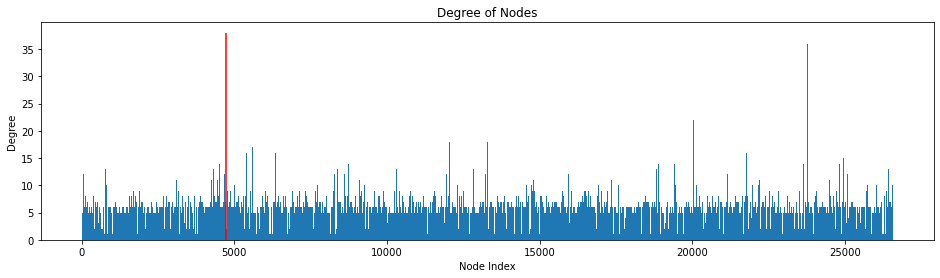

In [7]:
G = to_networkx(exp.data, to_undirected=True)

degrees = dict(nx.degree(G))
node_indices = list(degrees.keys())
node_degrees = list(degrees.values())
avg_degree = np.mean(node_degrees)

max_degree = max(node_degrees)
node_idx = np.argmax(node_degrees).item()

degreezero = [k for k,v in degrees.items() if v == 0]
degreeone = [k for k,v in degrees.items() if v == 1]
degreetwo = [k for k,v in degrees.items() if v == 2]

plt.figure(figsize=(16, 4))
plt.bar(node_indices, node_degrees, width=5.0)
plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')

plt.title('Degree of Nodes')
plt.xlabel('Node Index')
plt.ylabel('Degree')

print(f'Node {node_idx} has the largest degree value {max_degree}. Avg:  {avg_degree}')
print(f'Degree 0#: {len(degreezero)}, Degree 1#: {len(degreeone)}, Degree 2#: {len(degreetwo)}')

Text(0, 0.5, 'Number of Nodes')

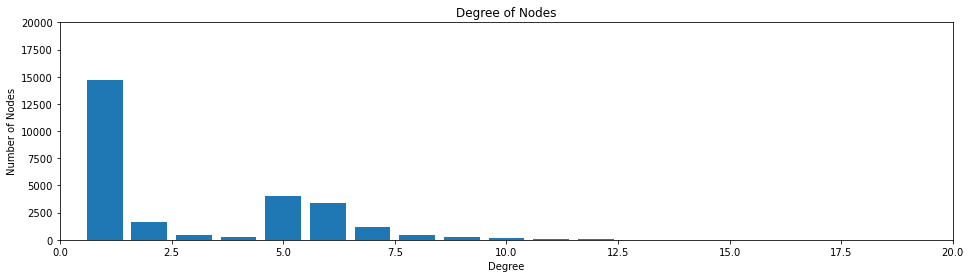

In [9]:
in_values = sorted(set(node_degrees))
in_hist = [list(node_degrees).count(x) for x in in_values]

plt.figure(figsize=(16, 4))
limits = [ 0, 20, 0, 20000]
plt.axis(limits)
plt.bar(in_values, in_hist)
# plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')

plt.title('Degree of Nodes')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')

Nodes with zero degree []


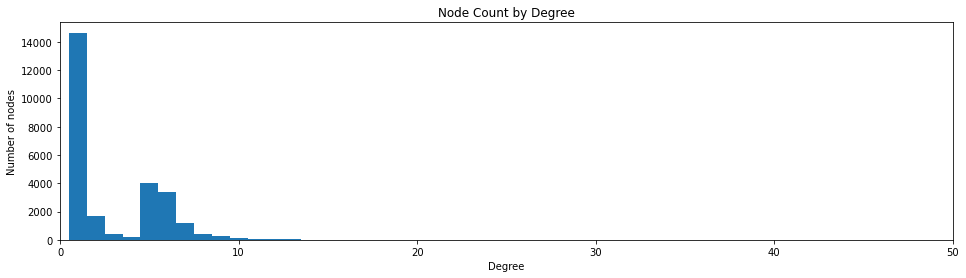

In [10]:
degreeval_dict = {}

zeroval_list = [k for k, v in degrees.items() if v == 0]
for k, v in degrees.items():
    degreeval_dict[v] = degreeval_dict.get(v, 0) + 1

y_nodecount = [degreeval_dict[k] for k in sorted(degreeval_dict)]
plt.figure(figsize=(16, 4))
plt.bar(sorted(degreeval_dict), y_nodecount, width=1.0)

plt.title('Node Count by Degree')
plt.xlabel('Degree')
plt.ylabel('Number of nodes');
plt.xlim([0, 20])

print('Nodes with zero degree', zeroval_list)

## 3. Analyze features

[  162   245   452 25714]


Text(0, 0.5, 'Number of Nodes')

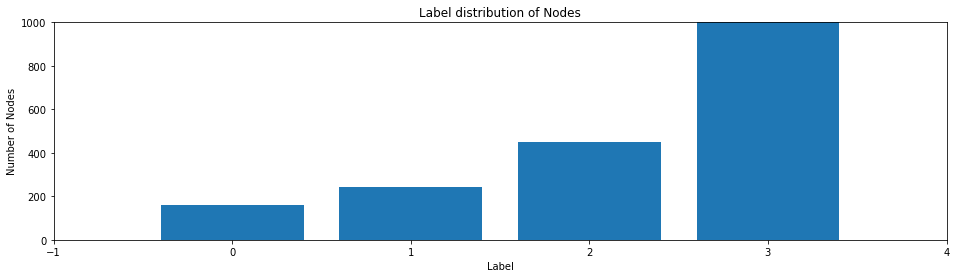

In [16]:
in_values = exp.nodes_df.groupby('label').sum()['feat_domain'].values
in_hist = list(range(4))
print(in_values)
plt.figure(figsize=(16, 4))
limits = [ -1, 4, 0, 1000]
plt.axis(limits)
plt.bar(in_hist, in_values)
# plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')

plt.title('Label distribution of Nodes')
plt.xlabel('Label')
plt.ylabel('Number of Nodes')

In [9]:
# exp.nodes_df[exp.nodes_df['label']<3]['label'].values
exp.nodes_df.groupby('label').sum()['feat_domain'].values

label
0      162
1      245
2      452
3    25714
Name: feat_domain, dtype: int64

In [21]:
info_df = pd.read_csv('../data/features_raw.csv')
info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26573 entries, 0 to 26572
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   node_id                      26573 non-null  int64  
 1   node                         26573 non-null  object 
 2   label                        26573 non-null  int64  
 3   alexa_rank                   17677 non-null  float64
 4   daily_pageviews_per_visitor  17684 non-null  float64
 5   daily_time_on_site           11799 non-null  float64
 6   total_sites_linking_in       25446 non-null  float64
 7   bounce_rate                  10665 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.6+ MB


## Audiance Overlap vs. Referral sites

In [3]:
ds_names = ["acl2020", "emnlp2018"]
tasks = ['fact', 'bias']
level = 0
ds_name = ds_names[0]
task = tasks[0]

df_aud_edge = pd.read_csv('../data/edges_{}_level{}.txt'.format(ds_name, level))
df_aud_nodes = pd.read_csv('../data/features_{}_level{}.txt'.format(ds_name, level))
df_aud_label = pd.read_csv('../data/labels_{}_{}.csv'.format(ds_name, task))

In [6]:
df_aud_nodes.head(2)

,node,alexa_rank,daily_pageviews_per_visitor,daily_time_on_site,total_sites_linking_in,bounce_rate
0,whatauto.expert,NaN,NaN,NaN,3.0,NaN
1,tulsahistory.org,408600.0,3.0,104.0,120.0,0.71


In [13]:
df_aud_label.head(2)

,node,label
0,crooked.com,2
1,deepleftfield.info,1


In [4]:
df_ref_edge = pd.read_csv("/export/sec02/nabeel/News-Media-Peers/alexa_data/corpus_2020_referral_edges.csv")

In [5]:
df_ref_edge.head(2)

,source,target
0,cp24.com,torontosun.com
1,liberalamerica.org,liberalamerica.life


In [15]:
ref_nodes = set(df_ref_edge['source'].unique()) | set(df_ref_edge['target'].unique())
aud_nodes = set(df_aud_nodes['node'].unique())
aud_labels = set(df_aud_label['node'].unique())

In [8]:
len(aud_nodes)

3489

In [9]:
len(ref_nodes)

2925

In [10]:
len(aud_nodes & ref_nodes)

2294

In [16]:
len(ref_nodes & aud_labels)

859